In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from lmfit import minimize, Model, Parameters
from lmfit.models import LorentzianModel
import glob

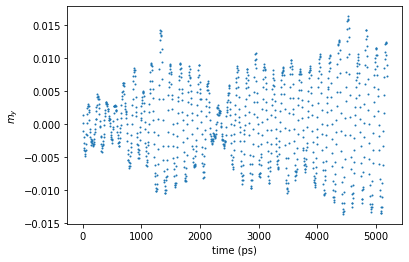

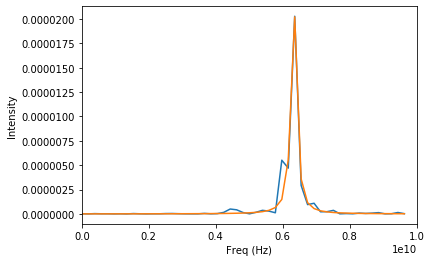

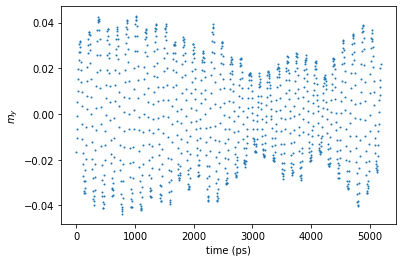

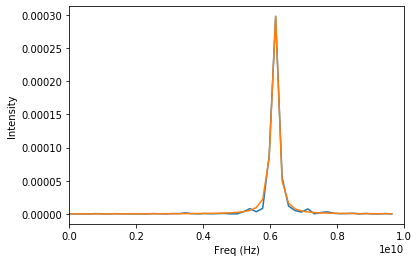

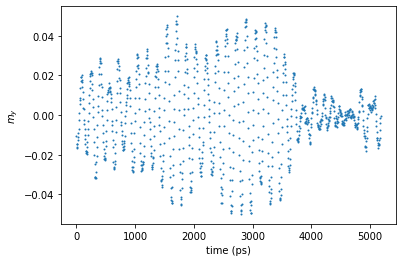

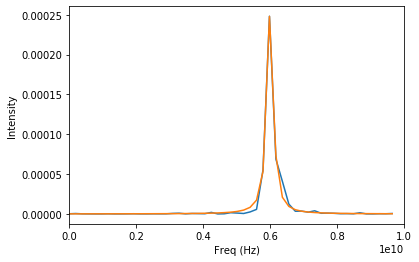

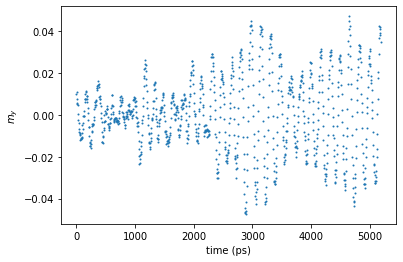

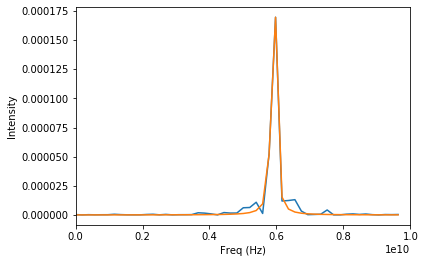

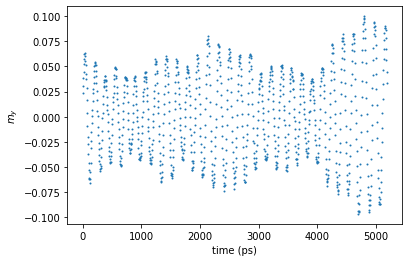

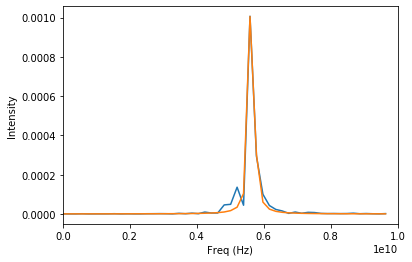

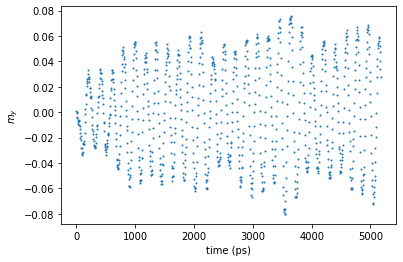

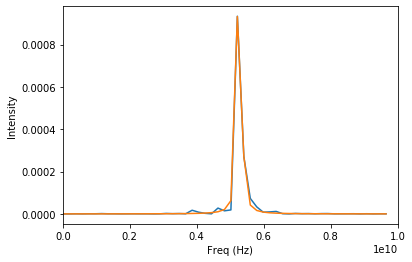

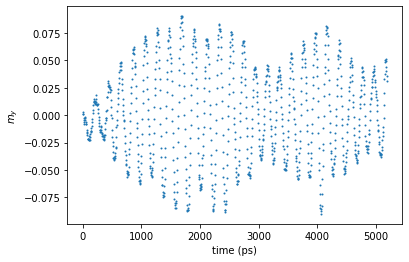

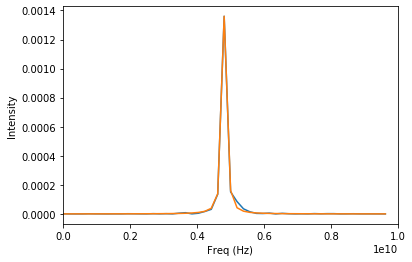

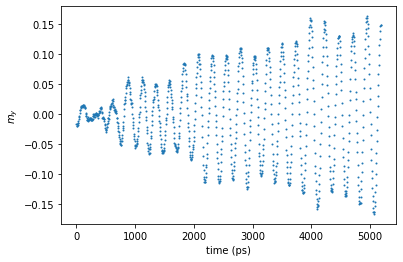

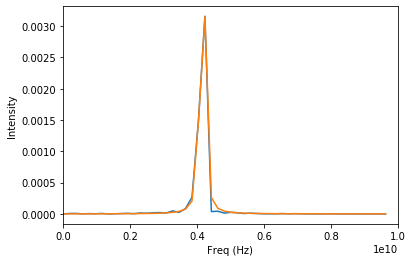

In [2]:
# Sean Stansill 2022-02-01 (ll14s26s@leeds.ac.uk)
# This script extracts the FMR frequency of a ferromagnet at finite temperature
# and compares the temperature scaling of Zeeman and uniaxial anisotropy
# terms with Callen-Callen theory.
#
# This script is Hamiltonian specific and temperature series specific. Any
# lines which contain these non-general parameters will be marked with an EDIT
# comment.



# Initialise containers for variables we wish to extract. The mz value is the one 
# we care about most--as with Bloch's law, we need a quantisation axis.
m = []
mz = []
fmr = []
fmr_err = []

# The power spectral density is best modelled as a Lorentzian, not a Gaussian.
# Initialize an lmfit Lorentzian class
psd_model =  LorentzianModel()


# Initialise psd parameters which are roughly known for the first in the
# temperature series
############################### EDIT ###############################
psd_params = psd_model.make_params(
    center=6500000000,
    amplitude=10000,
    sigma=100000000)

# Temperature list. We want this to be from smallest to largest so we can pass the
# fitting parameters as the initial guess for the next file. Simpler than a glob
# implementation
############################### EDIT ###############################
temp_list = ['10.0', '50.0', '100.0', '150.0', '200.0', '250.0', '300.0', '350.0']

# Loop over each temperature
for temp_dir in temp_list:
    
    # Read in the JAMS data. Needs to be changed dependent on file name
    ############################### EDIT ###############################
    RT_data = pd.read_table(f'BIGSYSTEM/{temp_dir}K/production_mag.tsv', sep='\s+')
    
    # Check the timeseries data looks normal
    plt.plot(RT_data['time'][::10], RT_data['A_my'][::10], 'o', ms=1)
    plt.xlabel('time (ps)')
    plt.ylabel(r'$m_y$')
    plt.show()
    
    # Take a Fourier transform of the timeseries data
    yfreq = fft(RT_data['A_mx'])

    # Define the number real time bins
    N = len(RT_data.index)

    # Define the time between samples
    t = 5e-1 * 1e-12
    
    # Use the in-built scipy function to make the correct number of frequency
    # bins for a given N and t
    xfreq = fftfreq(N, t)

    
    # Calculate explicitly the power spectral density. The fft is not directly the
    # PSD
    power= 2*(np.abs(yfreq/N))**2

    # Limit the data to positive frequencies only
    # xfreq is a strange shape. All positive values (including 0.0) come first.
    # Negative values are tacked on the end

    # This index is the last positive frequency
    index_max = np.where(xfreq==xfreq.max())


    # We want a frequency which is much smaller than the maximum positive freqency
    # The maximum frequency we expect is 6GHz (see config for details)
    xdat = xfreq[:int(index_max[0])]
    
    ############################### EDIT ###############################
    # 1e10 must be changed dependent on the maximum frequency expected in the Hamiltonian
    index_freq = max(np.where(xdat < 1e10)[0])

    
    # Concatonate the data for cleaner fitting
    xdat = xfreq[:int(index_freq)]
    ydat = power[:int(index_freq)]

    
    # The psd_model should be reinitialised so that the previous fit
    # doesn't interfere with the current fit
    psd_model =  LorentzianModel()

    # Now we try to fit it as a Lorentzian
    result = psd_model.fit(ydat, psd_params, x=xdat, max_nfev=100000)
    
    # Plot the fit against the PSD to check the fit is good
    plt.plot(xdat, ydat)
    plt.plot(xdat, result.best_fit)
    # expected frequency is ~6GHz so truncate the data to between 0 and 10GHz
    
    ############################### EDIT ###############################
    plt.xlim(0, 1e10)
    plt.xlabel('Freq (Hz)')
    plt.ylabel('Intensity')
    plt.show()

    
    # Now change the initial guess to the lower temperature fit. This
    # ensures our start guess is close to the actual value
    psd_params = psd_model.make_params(
        center=result.best_values['center'],
        amplitude=result.best_values['amplitude'],
        sigma=result.best_values['sigma']) 
    
    # Add the calcualted values to the lists defined at the beginning
    # of this cell
    fmr.append(result.best_values['center'])
    mz.append(RT_data['A_mz'].mean())
    m.append(RT_data['A_m'].mean())
    fmr_err.append(result.params['center'].stderr)

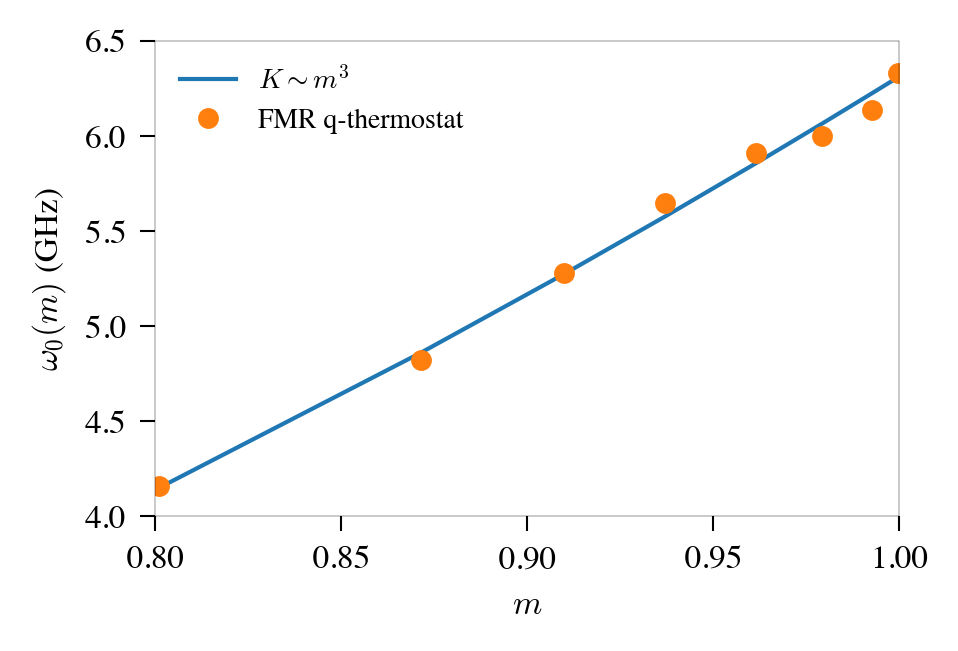

In [3]:
# Set pyploy rc params to something sensible using a style file
plt.style.use('aps-paper')

############################### EDIT ###############################
# This model is Hamiltonian specific. It is specific to a S=1/2 system
# with uniaxial anisotropy and a Zeeman field
def fmr_model(K1, B, mz):
    return (2/6.63e-34)*(9.274e-24*B + 2*K1*np.array(mz)**2)

############################### EDIT ###############################
# This is Hamiltonian specific and passes the strength of K1 and
# applied field to the epxected magnetisation scaling
f_scaling = fmr_model(1e-24, 0.01, mz)

# Plot and save the comparison of FMR scaling with magnetisation
# and simulation scaling
plt.figure()
plt.plot(mz, f_scaling, label=r'$K\sim m^3$')
plt.plot(mz, fmr, 'o', label='FMR q-thermostat')
plt.yticks(np.linspace(4e9, 6.5e9, 6), np.linspace(4.0, 6.5, 6))
plt.xlabel(r'$m$')
plt.ylabel(r'$\omega_0(m)$ (GHz)')
plt.legend()
plt.savefig('fmr_scaling')
plt.show()